In [2]:
import pandas as pd
import os
import pytz

In [3]:
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 실제 TTF 파일 경로 (예: 나눔고딕)
font_path = '/content/drive/MyDrive/NanumFontSetup_TTF_ALL/NanumGothic.ttf'

# 폰트 등록 및 적용
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [4]:
# 파일 불러오기
top_one_df = pd.read_parquet("/content/drive/MyDrive/data/one_time_buyers_all_events.parquet")
top_multi_df = pd.read_parquet("/content/drive/MyDrive/data/multi_buyers_all_events.parquet")

### 카테고리 3 결측치 처리

In [7]:
# category_lvl3가 결측치인 경우 category_lvl2로 대체
top_one_df['category_lvl3'] = top_one_df['category_lvl3'].fillna(top_one_df['category_lvl2'])
top_multi_df['category_lvl3'] = top_multi_df['category_lvl3'].fillna(top_multi_df['category_lvl2'])

# 분석 목표:
고객 재구매 유도 통한 고객 리텐션 향상

데이터 분석 목표: 1회 구매자 vs 2회 이상 구매자 나누어 분석 후, 재구매 요인 분석과 재구매 유도 방안 도출 (재구매하는 안 하는 이유와 재구매하는 이유 분석)

# 2회 이상 구매자의 첫->두 번째 구매에서 카테고리 변경 비율, 경로

In [8]:
# 구매 이벤트만 필터링
multi_purchase = top_multi_df[top_multi_df['event_type'] == 'purchase'].copy()

# 날짜 정렬
multi_purchase['event_date'] = pd.to_datetime(multi_purchase['event_date'])
multi_purchase = multi_purchase.sort_values(by=['user_id', 'event_date'])

# 유저별 구매 순서 부여
multi_purchase['purchase_order'] = multi_purchase.groupby('user_id').cumcount() + 1

# 첫 번째, 두 번째 구매만 추출
first_second = multi_purchase[multi_purchase['purchase_order'] <= 2]

# 첫/두 번째 구매를 하나의 행에 피벗
pivoted = first_second.pivot(index='user_id', columns='purchase_order', values='category_lvl1')
pivoted.columns = ['first_cat1', 'second_cat1']
pivoted = pivoted.dropna()

# 변경 여부 판단
pivoted['category_changed'] = pivoted['first_cat1'] != pivoted['second_cat1']

# 통계 요약
change_rate = pivoted['category_changed'].mean()
change_counts = pivoted['category_changed'].value_counts()

print("2회 이상 구매자의 첫→두번째 구매에서 카테고리 변경 비율:", round(change_rate, 3))
print("\n상세 분포:")
print(change_counts)


2회 이상 구매자의 첫→두번째 구매에서 카테고리 변경 비율: 0.219

상세 분포:
category_changed
False    503688
True     141510
Name: count, dtype: int64


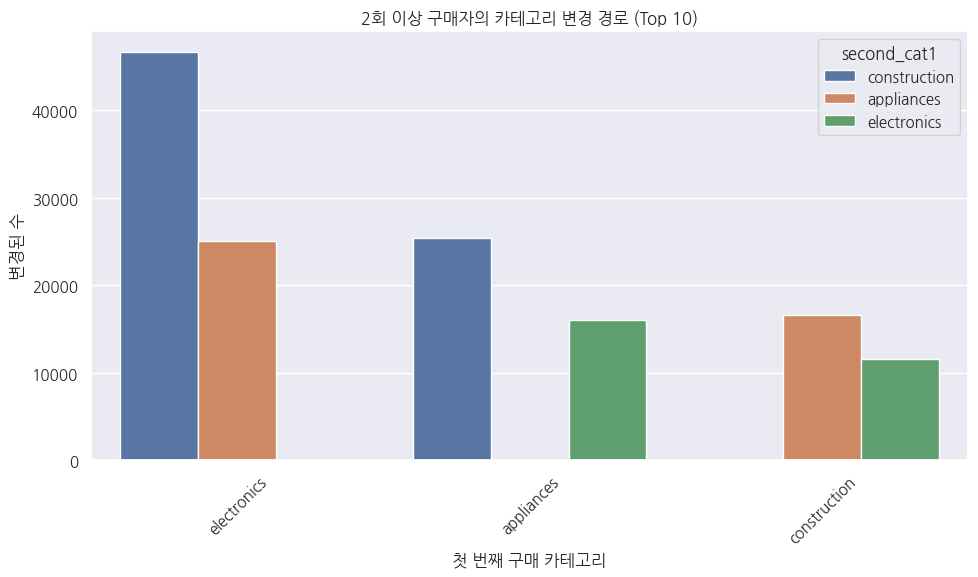

In [9]:
# 변경된 경우만 추출
changed_cases = pivoted[pivoted['category_changed']]

# 변화 경로 집계
change_paths = changed_cases.groupby(['first_cat1', 'second_cat1']).size().reset_index(name='count')
change_paths = change_paths.sort_values('count', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

# 상위 몇 개만 시각화
top_paths = change_paths.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_paths, y='count', x='first_cat1', hue='second_cat1')
plt.title('2회 이상 구매자의 카테고리 변경 경로 (Top 10)')
plt.xlabel('첫 번째 구매 카테고리')
plt.ylabel('변경된 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()